## Train a cellpose 2D model 

This notebook trains a cellpose 2d model to find the bees as suggested by Olivier Burri on [this imagesc question](https://forum.image.sc/t/how-to-count-bees-pattern-recognition-and-segmentation/90115)

Images for this example can be found [here](https://www.dropbox.com/scl/fo/joc3l8p0d3ewhn7rx202y/h?rlkey=hc4kgy1gv2xpq4udcm11mjwm0&dl=0)

Before running this notebook a set of patches must exist in the following format.

1.  Ground Truth are put in a directory called ```/ground truth0```
2.  Inputs are put in a directory called ```inputn``` where n is an integer 0...m and represents the channel.  Note:  RGB images may only have one 'channel' directory.
3.  In each of the both directories there exist a set of files of the same names.  For example if in the ```inputn``` directory we have ```apples0```, ```apples1```, ```apples2``` label images of the same name must exist in the ```ground truth``` directory.  

In [1]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
import tensorflow as tf
from cellpose import models, io
from pathlib import Path

## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [2]:
tnia_images_path = Path(r"D:\images\tnia-python-images")
parent_path=Path(tnia_images_path / r'imagesc/2024_03_18_this_cant_possibly_work')


train_path = os.path.join(parent_path, 'patches')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'model')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Use a helper to collect the training data

The helper will also normalize the inputs.

In [12]:
from tnia.deeplearning.dl_helper import collect_training_data
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, add_trivial_channel=False)

print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

Number of input images 1400
Number of ground truth images  1400
Size of first input image (256, 256, 3)
Size of first ground truth image  (256, 256)


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

(256, 256, 3) (256, 256)
-0.21599856 1.0100803
2024-03-18 18:21:26,223 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


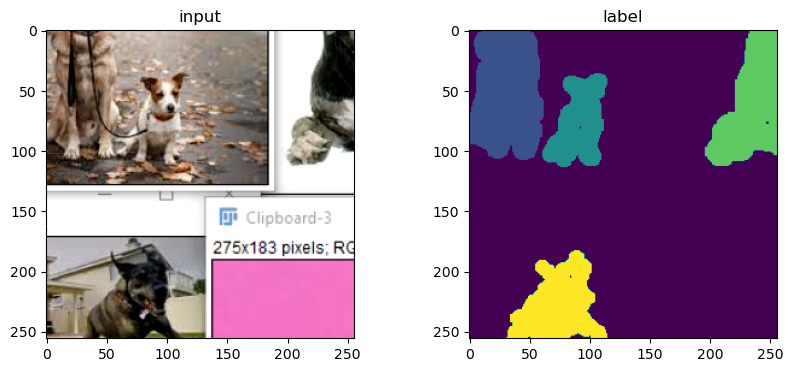

In [13]:

print(X[0].shape, Y[0].shape)
print(X[0].min(), X[0].max())
fig=imshow_multi2d([X[2], Y[2]], ['input', 'label'], 1,2)

## Divide into training and validation sets

Unlike stardist Cellpose does not seem to need numpy arrays as input.  So to create training and validation sets we can simply split the X and Y vectors. 

In [14]:

X_ = X.copy()
Y_ = Y.copy()

# note we don't have a lot of training patches so we will use them for both training and testing (very bad but this is just for proof of concept)

X_train = X_
Y_train = Y_
X_test = X_.copy()
Y_test = Y_.copy()

print('Number of images', len(X_))
print('Number of training images', len(X_train))
print('Number of test images ', len(X_test))



Number of images 1400
Number of training images 1400
Number of test images  1400


In [15]:
X_train[0].shape, Y_train[0].shape

((256, 256, 3), (256, 256))

## Create a cellpose model

In [16]:
import os

model_name = 'cellpose_for_dogs'

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model= models.CellposeModel(gpu=True, model_type=None, pretrained_model=os.path.join(model_path,'models',model_name))

creating new log file
2024-03-18 18:21:31,071 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2024-03-18 18:21:31,072 [INFO] 
cellpose version: 	2.2.3 
platform:       	win32 
python version: 	3.9.16 
torch version:  	2.1.2+cpu
2024-03-18 18:21:31,074 [WARNING] pretrained model has incorrect path
2024-03-18 18:21:31,075 [INFO] >> cyto << model set to be used
2024-03-18 18:21:31,077 [INFO] TORCH CUDA version not installed/working.
2024-03-18 18:21:31,079 [INFO] >>>> using CPU
2024-03-18 18:21:31,206 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


# Train the model

In [17]:
model_path

'D:\\images\\tnia-python-images\\imagesc\\2024_03_18_this_cant_possibly_work\\model'

In [45]:
help(model.train)

Help on method train in module cellpose.models:

train(train_data, train_labels, train_files=None, test_data=None, test_labels=None, test_files=None, channels=None, normalize=True, save_path=None, save_every=100, save_each=False, learning_rate=0.2, n_epochs=500, momentum=0.9, SGD=True, weight_decay=1e-05, batch_size=8, nimg_per_epoch=None, rescale=True, min_train_masks=5, model_name=None) method of cellpose.models.CellposeModel instance
    train network with images train_data 
    
    Parameters
    ------------------
    
    train_data: list of arrays (2D or 3D)
        images for training
    
    train_labels: list of arrays (2D or 3D)
        labels for train_data, where 0=no masks; 1,2,...=mask labels
        can include flows as additional images
    
    train_files: list of strings
        file names for images in train_data (to save flows for future runs)
    
    test_data: list of arrays (2D or 3D)
        images for testing
    
    test_labels: list of arrays (2D or 3D)

In [22]:

new_model_path = model.train(X_train, Y_train, 
                              #test_data=X_val,
                              #test_labels=Y_val,
                              channels=[0,1], 
                              save_path=model_path, 
                              n_epochs=40,
                              min_train_masks=0,
                              #learning_rate=learning_rate, 
                              #weight_decay=weight_decay, 
                              nimg_per_epoch=100,
                              model_name=model_name)

2024-03-18 18:44:57,573 [INFO] computing flows for labels


  0%|          | 1/1400 [00:00<02:30,  9.27it/s]

2024-03-18 18:44:57,920 [WARNING] empty masks!


  0%|          | 7/1400 [00:00<01:29, 15.61it/s]

2024-03-18 18:44:58,290 [WARNING] empty masks!
2024-03-18 18:44:58,292 [WARNING] empty masks!
2024-03-18 18:44:58,362 [WARNING] empty masks!


  1%|▏         | 18/1400 [00:02<04:08,  5.55it/s]

2024-03-18 18:45:00,211 [WARNING] empty masks!
2024-03-18 18:45:00,213 [WARNING] empty masks!


  2%|▏         | 25/1400 [00:02<02:32,  9.03it/s]

2024-03-18 18:45:00,499 [WARNING] empty masks!
2024-03-18 18:45:00,596 [WARNING] empty masks!


  2%|▎         | 35/1400 [00:04<04:39,  4.89it/s]

2024-03-18 18:45:02,772 [WARNING] empty masks!


  3%|▎         | 40/1400 [00:05<04:15,  5.31it/s]

2024-03-18 18:45:03,476 [WARNING] empty masks!


  4%|▍         | 54/1400 [00:10<07:49,  2.87it/s]

2024-03-18 18:45:08,030 [WARNING] empty masks!


  4%|▍         | 57/1400 [00:10<04:55,  4.54it/s]

2024-03-18 18:45:08,157 [WARNING] empty masks!


  4%|▍         | 61/1400 [00:10<02:58,  7.52it/s]

2024-03-18 18:45:08,264 [WARNING] empty masks!


  5%|▍         | 65/1400 [00:10<02:02, 10.93it/s]

2024-03-18 18:45:08,366 [WARNING] empty masks!


  6%|▌         | 77/1400 [00:12<03:19,  6.63it/s]

2024-03-18 18:45:10,010 [WARNING] empty masks!
2024-03-18 18:45:10,011 [WARNING] empty masks!


  6%|▌         | 82/1400 [00:12<03:11,  6.90it/s]

2024-03-18 18:45:10,694 [WARNING] empty masks!


  6%|▌         | 86/1400 [00:14<04:15,  5.14it/s]

2024-03-18 18:45:11,889 [WARNING] empty masks!
2024-03-18 18:45:11,950 [WARNING] empty masks!


  7%|▋         | 104/1400 [00:16<03:03,  7.06it/s]

2024-03-18 18:45:14,018 [WARNING] empty masks!


  8%|▊         | 107/1400 [00:16<03:54,  5.51it/s]

2024-03-18 18:45:14,753 [WARNING] empty masks!


  8%|▊         | 110/1400 [00:17<03:36,  5.96it/s]

2024-03-18 18:45:15,166 [WARNING] empty masks!
2024-03-18 18:45:15,215 [WARNING] empty masks!


  8%|▊         | 115/1400 [00:18<03:22,  6.35it/s]

2024-03-18 18:45:15,977 [WARNING] empty masks!
2024-03-18 18:45:15,979 [WARNING] empty masks!


  9%|▉         | 126/1400 [00:19<02:56,  7.24it/s]

2024-03-18 18:45:17,573 [WARNING] empty masks!


  9%|▉         | 128/1400 [00:19<03:12,  6.60it/s]

2024-03-18 18:45:17,576 [WARNING] empty masks!
2024-03-18 18:45:17,625 [WARNING] empty masks!


 10%|▉         | 138/1400 [00:21<03:33,  5.91it/s]

2024-03-18 18:45:19,043 [WARNING] empty masks!
2024-03-18 18:45:19,118 [WARNING] empty masks!


 10%|█         | 144/1400 [00:21<02:08,  9.75it/s]

2024-03-18 18:45:19,198 [WARNING] empty masks!
2024-03-18 18:45:19,200 [WARNING] empty masks!
2024-03-18 18:45:19,271 [WARNING] empty masks!
2024-03-18 18:45:19,272 [WARNING] empty masks!


 11%|█         | 154/1400 [00:21<01:29, 13.94it/s]

2024-03-18 18:45:19,607 [WARNING] empty masks!


 11%|█▏        | 158/1400 [00:21<01:16, 16.34it/s]

2024-03-18 18:45:19,819 [WARNING] empty masks!
2024-03-18 18:45:19,821 [WARNING] empty masks!
2024-03-18 18:45:19,822 [WARNING] empty masks!
2024-03-18 18:45:19,824 [WARNING] empty masks!


 12%|█▏        | 169/1400 [00:22<01:45, 11.69it/s]

2024-03-18 18:45:20,769 [WARNING] empty masks!


 13%|█▎        | 178/1400 [00:24<03:29,  5.82it/s]

2024-03-18 18:45:22,653 [WARNING] empty masks!
2024-03-18 18:45:22,718 [WARNING] empty masks!


 13%|█▎        | 183/1400 [00:25<02:24,  8.45it/s]

2024-03-18 18:45:22,824 [WARNING] empty masks!


 13%|█▎        | 186/1400 [00:25<02:08,  9.46it/s]

2024-03-18 18:45:23,026 [WARNING] empty masks!


 13%|█▎        | 188/1400 [00:25<03:08,  6.42it/s]

2024-03-18 18:45:23,759 [WARNING] empty masks!


 14%|█▍        | 193/1400 [00:26<03:48,  5.28it/s]

2024-03-18 18:45:24,803 [WARNING] empty masks!
2024-03-18 18:45:24,805 [WARNING] empty masks!


 14%|█▍        | 199/1400 [00:27<03:20,  6.00it/s]

2024-03-18 18:45:25,951 [WARNING] empty masks!


 14%|█▍        | 201/1400 [00:28<03:37,  5.52it/s]

2024-03-18 18:45:25,954 [WARNING] empty masks!
2024-03-18 18:45:26,036 [WARNING] empty masks!


 15%|█▍        | 208/1400 [00:28<01:51, 10.69it/s]

2024-03-18 18:45:26,086 [WARNING] empty masks!
2024-03-18 18:45:26,088 [WARNING] empty masks!


 15%|█▌        | 212/1400 [00:29<02:27,  8.03it/s]

2024-03-18 18:45:26,866 [WARNING] empty masks!
2024-03-18 18:45:26,867 [WARNING] empty masks!
2024-03-18 18:45:26,918 [WARNING] empty masks!


 16%|█▌        | 222/1400 [00:29<01:59,  9.87it/s]

2024-03-18 18:45:28,232 [WARNING] empty masks!


 16%|█▋        | 231/1400 [00:31<02:26,  7.97it/s]

2024-03-18 18:45:29,208 [WARNING] empty masks!
2024-03-18 18:45:29,210 [WARNING] empty masks!
2024-03-18 18:45:29,212 [WARNING] empty masks!
2024-03-18 18:45:29,213 [WARNING] empty masks!
2024-03-18 18:45:29,259 [WARNING] empty masks!


 18%|█▊        | 253/1400 [00:34<03:09,  6.05it/s]

2024-03-18 18:45:31,955 [WARNING] empty masks!


 18%|█▊        | 258/1400 [00:35<04:30,  4.21it/s]

2024-03-18 18:45:33,653 [WARNING] empty masks!


 19%|█▉        | 263/1400 [00:35<02:44,  6.93it/s]

2024-03-18 18:45:33,786 [WARNING] empty masks!
2024-03-18 18:45:33,788 [WARNING] empty masks!


 19%|█▉        | 267/1400 [00:36<02:56,  6.43it/s]

2024-03-18 18:45:34,465 [WARNING] empty masks!


 19%|█▉        | 271/1400 [00:37<02:41,  7.00it/s]

2024-03-18 18:45:34,918 [WARNING] empty masks!


 20%|█▉        | 273/1400 [00:37<02:22,  7.89it/s]

2024-03-18 18:45:35,105 [WARNING] empty masks!


 20%|█▉        | 276/1400 [00:37<02:02,  9.20it/s]

2024-03-18 18:45:35,226 [WARNING] empty masks!


 20%|██        | 282/1400 [00:38<01:58,  9.40it/s]

2024-03-18 18:45:35,861 [WARNING] empty masks!
2024-03-18 18:45:35,940 [WARNING] empty masks!


 21%|██        | 288/1400 [00:38<01:52,  9.91it/s]

2024-03-18 18:45:36,499 [WARNING] empty masks!
2024-03-18 18:45:36,502 [WARNING] empty masks!


 21%|██        | 292/1400 [00:38<01:28, 12.53it/s]

2024-03-18 18:45:37,056 [WARNING] empty masks!


 21%|██        | 294/1400 [00:39<02:02,  9.05it/s]

2024-03-18 18:45:37,058 [WARNING] empty masks!


 21%|██▏       | 300/1400 [00:39<01:24, 13.05it/s]

2024-03-18 18:45:37,300 [WARNING] empty masks!


 22%|██▏       | 310/1400 [00:41<03:13,  5.62it/s]

2024-03-18 18:45:39,112 [WARNING] empty masks!


 23%|██▎       | 319/1400 [00:42<02:16,  7.95it/s]

2024-03-18 18:45:40,089 [WARNING] empty masks!


 23%|██▎       | 326/1400 [00:42<01:20, 13.32it/s]

2024-03-18 18:45:40,444 [WARNING] empty masks!


 24%|██▍       | 333/1400 [00:44<03:35,  4.96it/s]

2024-03-18 18:45:42,601 [WARNING] empty masks!


 24%|██▍       | 338/1400 [00:45<02:46,  6.39it/s]

2024-03-18 18:45:43,143 [WARNING] empty masks!


 26%|██▌       | 358/1400 [00:49<03:17,  5.28it/s]

2024-03-18 18:45:46,991 [WARNING] empty masks!
2024-03-18 18:45:47,073 [WARNING] empty masks!


 26%|██▋       | 370/1400 [00:51<04:07,  4.16it/s]

2024-03-18 18:45:49,584 [WARNING] empty masks!


 27%|██▋       | 373/1400 [00:52<05:07,  3.34it/s]

2024-03-18 18:45:50,758 [WARNING] empty masks!


 27%|██▋       | 378/1400 [00:53<03:26,  4.96it/s]

2024-03-18 18:45:51,451 [WARNING] empty masks!


 28%|██▊       | 390/1400 [00:56<02:54,  5.80it/s]

2024-03-18 18:45:54,385 [WARNING] empty masks!
2024-03-18 18:45:54,386 [WARNING] empty masks!


 28%|██▊       | 394/1400 [00:56<01:48,  9.30it/s]

2024-03-18 18:45:54,503 [WARNING] empty masks!


 28%|██▊       | 397/1400 [00:57<03:15,  5.12it/s]

2024-03-18 18:45:55,631 [WARNING] empty masks!


 29%|██▊       | 402/1400 [00:58<03:30,  4.75it/s]

2024-03-18 18:45:56,672 [WARNING] empty masks!
2024-03-18 18:45:56,674 [WARNING] empty masks!


 29%|██▉       | 411/1400 [01:00<02:44,  6.01it/s]

2024-03-18 18:45:57,884 [WARNING] empty masks!


 30%|███       | 420/1400 [01:02<03:52,  4.21it/s]

2024-03-18 18:45:59,844 [WARNING] empty masks!


 30%|███       | 422/1400 [01:02<03:07,  5.23it/s]

2024-03-18 18:45:59,960 [WARNING] empty masks!
2024-03-18 18:46:00,027 [WARNING] empty masks!


 31%|███       | 429/1400 [01:02<01:33, 10.36it/s]

2024-03-18 18:46:00,111 [WARNING] empty masks!
2024-03-18 18:46:00,113 [WARNING] empty masks!


 32%|███▏      | 444/1400 [01:06<04:35,  3.47it/s]

2024-03-18 18:46:04,100 [WARNING] empty masks!
2024-03-18 18:46:04,112 [WARNING] empty masks!


 33%|███▎      | 465/1400 [01:09<02:40,  5.82it/s]

2024-03-18 18:46:07,701 [WARNING] empty masks!
2024-03-18 18:46:07,762 [WARNING] empty masks!
2024-03-18 18:46:07,763 [WARNING] empty masks!


 34%|███▎      | 471/1400 [01:10<02:09,  7.18it/s]

2024-03-18 18:46:08,356 [WARNING] empty masks!


 34%|███▍      | 479/1400 [01:12<03:50,  3.99it/s]

2024-03-18 18:46:10,410 [WARNING] empty masks!
2024-03-18 18:46:10,411 [WARNING] empty masks!


 34%|███▍      | 483/1400 [01:13<03:49,  3.99it/s]

2024-03-18 18:46:11,353 [WARNING] empty masks!


 36%|███▌      | 497/1400 [01:16<03:01,  4.98it/s]

2024-03-18 18:46:13,975 [WARNING] empty masks!
2024-03-18 18:46:14,025 [WARNING] empty masks!


 36%|███▌      | 507/1400 [01:17<02:43,  5.47it/s]

2024-03-18 18:46:15,354 [WARNING] empty masks!
2024-03-18 18:46:15,355 [WARNING] empty masks!
2024-03-18 18:46:15,356 [WARNING] empty masks!
2024-03-18 18:46:15,363 [WARNING] empty masks!


 37%|███▋      | 514/1400 [01:17<01:19, 11.20it/s]

2024-03-18 18:46:15,460 [WARNING] empty masks!
2024-03-18 18:46:16,246 [WARNING] empty masks!


 37%|███▋      | 521/1400 [01:18<01:53,  7.74it/s]

2024-03-18 18:46:16,881 [WARNING] empty masks!


 39%|███▊      | 540/1400 [01:22<03:23,  4.22it/s]

2024-03-18 18:46:20,125 [WARNING] empty masks!


 39%|███▉      | 549/1400 [01:23<02:45,  5.16it/s]

2024-03-18 18:46:21,454 [WARNING] empty masks!
2024-03-18 18:46:21,456 [WARNING] empty masks!


 40%|███▉      | 553/1400 [01:23<01:48,  7.77it/s]

2024-03-18 18:46:21,628 [WARNING] empty masks!


 40%|███▉      | 559/1400 [01:24<02:39,  5.27it/s]

2024-03-18 18:46:22,823 [WARNING] empty masks!


 40%|████      | 564/1400 [01:25<01:41,  8.25it/s]

2024-03-18 18:46:22,927 [WARNING] empty masks!


 40%|████      | 566/1400 [01:25<01:47,  7.76it/s]

2024-03-18 18:46:23,246 [WARNING] empty masks!


 41%|████      | 568/1400 [01:25<02:00,  6.89it/s]

2024-03-18 18:46:23,653 [WARNING] empty masks!


 41%|████      | 570/1400 [01:25<01:42,  8.12it/s]

2024-03-18 18:46:23,853 [WARNING] empty masks!


 42%|████▏     | 582/1400 [01:27<01:43,  7.87it/s]

2024-03-18 18:46:25,527 [WARNING] empty masks!


 42%|████▏     | 585/1400 [01:27<01:19, 10.24it/s]

2024-03-18 18:46:25,711 [WARNING] empty masks!
2024-03-18 18:46:25,713 [WARNING] empty masks!
2024-03-18 18:46:25,714 [WARNING] empty masks!
2024-03-18 18:46:25,716 [WARNING] empty masks!


 42%|████▎     | 595/1400 [01:28<00:48, 16.56it/s]

2024-03-18 18:46:25,991 [WARNING] empty masks!
2024-03-18 18:46:25,992 [WARNING] empty masks!


 43%|████▎     | 601/1400 [01:28<00:34, 22.94it/s]

2024-03-18 18:46:26,154 [WARNING] empty masks!


 43%|████▎     | 605/1400 [01:28<00:30, 25.99it/s]

2024-03-18 18:46:26,351 [WARNING] empty masks!


 44%|████▍     | 613/1400 [01:30<01:49,  7.21it/s]

2024-03-18 18:46:27,886 [WARNING] empty masks!


 44%|████▍     | 616/1400 [01:30<02:00,  6.50it/s]

2024-03-18 18:46:29,030 [WARNING] empty masks!


 44%|████▍     | 618/1400 [01:31<02:17,  5.70it/s]

2024-03-18 18:46:29,536 [WARNING] empty masks!


 45%|████▍     | 629/1400 [01:33<02:07,  6.04it/s]

2024-03-18 18:46:30,914 [WARNING] empty masks!


 46%|████▌     | 645/1400 [01:35<01:36,  7.84it/s]

2024-03-18 18:46:33,214 [WARNING] empty masks!


 46%|████▋     | 648/1400 [01:35<01:17,  9.66it/s]

2024-03-18 18:46:33,383 [WARNING] empty masks!


 46%|████▋     | 651/1400 [01:35<01:02, 12.05it/s]

2024-03-18 18:46:33,504 [WARNING] empty masks!


 47%|████▋     | 657/1400 [01:37<02:39,  4.67it/s]

2024-03-18 18:46:35,390 [WARNING] empty masks!


 47%|████▋     | 660/1400 [01:38<02:33,  4.81it/s]

2024-03-18 18:46:36,008 [WARNING] empty masks!


 48%|████▊     | 667/1400 [01:38<01:52,  6.54it/s]

2024-03-18 18:46:36,770 [WARNING] empty masks!
2024-03-18 18:46:36,771 [WARNING] empty masks!
2024-03-18 18:46:36,773 [WARNING] empty masks!


 48%|████▊     | 673/1400 [01:39<01:25,  8.48it/s]

2024-03-18 18:46:37,282 [WARNING] empty masks!


 48%|████▊     | 677/1400 [01:40<02:24,  5.00it/s]

2024-03-18 18:46:38,271 [WARNING] empty masks!


 49%|████▉     | 687/1400 [01:42<02:26,  4.86it/s]

2024-03-18 18:46:40,085 [WARNING] empty masks!


 50%|█████     | 704/1400 [01:45<01:55,  6.01it/s]

2024-03-18 18:46:43,609 [WARNING] empty masks!


 51%|█████     | 715/1400 [01:47<01:50,  6.22it/s]

2024-03-18 18:46:45,251 [WARNING] empty masks!


 51%|█████     | 717/1400 [01:47<01:29,  7.62it/s]

2024-03-18 18:46:45,444 [WARNING] empty masks!


 52%|█████▏    | 721/1400 [01:47<01:22,  8.19it/s]

2024-03-18 18:46:45,804 [WARNING] empty masks!


 52%|█████▏    | 730/1400 [01:49<01:23,  8.00it/s]

2024-03-18 18:46:46,960 [WARNING] empty masks!


 52%|█████▏    | 733/1400 [01:49<01:05, 10.19it/s]

2024-03-18 18:46:47,112 [WARNING] empty masks!


 53%|█████▎    | 737/1400 [01:50<02:21,  4.70it/s]

2024-03-18 18:46:48,528 [WARNING] empty masks!
2024-03-18 18:46:48,530 [WARNING] empty masks!


 53%|█████▎    | 746/1400 [01:50<01:00, 10.89it/s]

2024-03-18 18:46:48,687 [WARNING] empty masks!


 54%|█████▎    | 749/1400 [01:51<01:04, 10.07it/s]

2024-03-18 18:46:49,044 [WARNING] empty masks!


 54%|█████▎    | 751/1400 [01:51<01:41,  6.37it/s]

2024-03-18 18:46:49,785 [WARNING] empty masks!


 54%|█████▍    | 754/1400 [01:52<01:18,  8.21it/s]

2024-03-18 18:46:49,932 [WARNING] empty masks!


 55%|█████▍    | 763/1400 [01:54<02:10,  4.87it/s]

2024-03-18 18:46:52,174 [WARNING] empty masks!


 55%|█████▍    | 766/1400 [01:54<01:33,  6.75it/s]

2024-03-18 18:46:52,310 [WARNING] empty masks!


 55%|█████▍    | 769/1400 [01:55<02:15,  4.67it/s]

2024-03-18 18:46:53,372 [WARNING] empty masks!


 56%|█████▌    | 777/1400 [01:56<01:28,  7.05it/s]

2024-03-18 18:46:54,082 [WARNING] empty masks!


 56%|█████▌    | 781/1400 [01:56<01:05,  9.40it/s]

2024-03-18 18:46:54,236 [WARNING] empty masks!


 56%|█████▋    | 789/1400 [01:59<02:42,  3.76it/s]

2024-03-18 18:46:57,295 [WARNING] empty masks!


 57%|█████▋    | 792/1400 [01:59<01:58,  5.13it/s]

2024-03-18 18:46:57,390 [WARNING] empty masks!


 57%|█████▋    | 798/1400 [01:59<01:14,  8.06it/s]

2024-03-18 18:46:57,637 [WARNING] empty masks!


 58%|█████▊    | 809/1400 [02:02<02:06,  4.68it/s]

2024-03-18 18:47:00,771 [WARNING] empty masks!


 58%|█████▊    | 812/1400 [02:03<01:20,  7.29it/s]

2024-03-18 18:47:00,903 [WARNING] empty masks!


 58%|█████▊    | 814/1400 [02:03<01:05,  8.93it/s]

2024-03-18 18:47:01,016 [WARNING] empty masks!


 58%|█████▊    | 819/1400 [02:03<01:14,  7.84it/s]

2024-03-18 18:47:01,750 [WARNING] empty masks!


 59%|█████▉    | 824/1400 [02:04<00:48, 12.00it/s]

2024-03-18 18:47:02,716 [WARNING] empty masks!


 59%|█████▉    | 832/1400 [02:06<01:53,  5.01it/s]

2024-03-18 18:47:04,342 [WARNING] empty masks!


 61%|██████    | 851/1400 [02:08<00:40, 13.47it/s]

2024-03-18 18:47:06,131 [WARNING] empty masks!


 61%|██████    | 854/1400 [02:08<00:47, 11.38it/s]

2024-03-18 18:47:06,574 [WARNING] empty masks!


 62%|██████▏   | 863/1400 [02:10<02:05,  4.29it/s]

2024-03-18 18:47:08,501 [WARNING] empty masks!


 62%|██████▏   | 867/1400 [02:11<01:45,  5.04it/s]

2024-03-18 18:47:09,207 [WARNING] empty masks!
2024-03-18 18:47:09,292 [WARNING] empty masks!
2024-03-18 18:47:09,294 [WARNING] empty masks!
2024-03-18 18:47:09,300 [WARNING] empty masks!


 62%|██████▎   | 875/1400 [02:11<00:47, 11.00it/s]

2024-03-18 18:47:09,375 [WARNING] empty masks!


 64%|██████▎   | 889/1400 [02:13<00:58,  8.68it/s]

2024-03-18 18:47:10,947 [WARNING] empty masks!
2024-03-18 18:47:10,948 [WARNING] empty masks!
2024-03-18 18:47:10,955 [WARNING] empty masks!


 64%|██████▍   | 902/1400 [02:15<01:12,  6.84it/s]

2024-03-18 18:47:13,006 [WARNING] empty masks!


 65%|██████▍   | 905/1400 [02:15<01:24,  5.89it/s]

2024-03-18 18:47:13,620 [WARNING] empty masks!


 65%|██████▍   | 907/1400 [02:15<01:12,  6.83it/s]

2024-03-18 18:47:13,755 [WARNING] empty masks!


 65%|██████▌   | 911/1400 [02:16<00:49,  9.84it/s]

2024-03-18 18:47:13,887 [WARNING] empty masks!


 66%|██████▋   | 929/1400 [02:19<01:34,  4.99it/s]

2024-03-18 18:47:16,954 [WARNING] empty masks!


 67%|██████▋   | 933/1400 [02:19<00:56,  8.33it/s]

2024-03-18 18:47:16,963 [WARNING] empty masks!


 67%|██████▋   | 938/1400 [02:19<00:35, 12.96it/s]

2024-03-18 18:47:17,087 [WARNING] empty masks!


 67%|██████▋   | 941/1400 [02:19<00:44, 10.26it/s]

2024-03-18 18:47:17,535 [WARNING] empty masks!


 67%|██████▋   | 943/1400 [02:19<00:41, 11.04it/s]

2024-03-18 18:47:17,666 [WARNING] empty masks!


 68%|██████▊   | 946/1400 [02:20<00:47,  9.60it/s]

2024-03-18 18:47:18,069 [WARNING] empty masks!


 68%|██████▊   | 959/1400 [02:22<00:58,  7.54it/s]

2024-03-18 18:47:20,027 [WARNING] empty masks!


 69%|██████▉   | 963/1400 [02:22<00:40, 10.86it/s]

2024-03-18 18:47:20,768 [WARNING] empty masks!


 69%|██████▉   | 966/1400 [02:22<00:55,  7.87it/s]

2024-03-18 18:47:20,848 [WARNING] empty masks!


 70%|██████▉   | 977/1400 [02:24<01:03,  6.62it/s]

2024-03-18 18:47:22,282 [WARNING] empty masks!


 70%|███████   | 981/1400 [02:24<00:43,  9.63it/s]

2024-03-18 18:47:22,434 [WARNING] empty masks!
2024-03-18 18:47:22,436 [WARNING] empty masks!
2024-03-18 18:47:22,437 [WARNING] empty masks!
2024-03-18 18:47:22,439 [WARNING] empty masks!
2024-03-18 18:47:22,465 [WARNING] empty masks!
2024-03-18 18:47:22,467 [WARNING] empty masks!


 71%|███████   | 993/1400 [02:25<00:52,  7.80it/s]

2024-03-18 18:47:23,739 [WARNING] empty masks!


 71%|███████   | 996/1400 [02:26<00:56,  7.12it/s]

2024-03-18 18:47:24,621 [WARNING] empty masks!


 72%|███████▏  | 1004/1400 [02:28<01:20,  4.92it/s]

2024-03-18 18:47:26,309 [WARNING] empty masks!


 72%|███████▏  | 1009/1400 [02:29<01:13,  5.34it/s]

2024-03-18 18:47:27,372 [WARNING] empty masks!


 72%|███████▏  | 1012/1400 [02:30<01:10,  5.51it/s]

2024-03-18 18:47:27,854 [WARNING] empty masks!


 72%|███████▎  | 1015/1400 [02:30<00:52,  7.30it/s]

2024-03-18 18:47:27,999 [WARNING] empty masks!
2024-03-18 18:47:28,001 [WARNING] empty masks!


 73%|███████▎  | 1024/1400 [02:31<00:44,  8.39it/s]

2024-03-18 18:47:28,984 [WARNING] empty masks!


 73%|███████▎  | 1028/1400 [02:31<00:30, 12.09it/s]

2024-03-18 18:47:29,174 [WARNING] empty masks!
2024-03-18 18:47:29,176 [WARNING] empty masks!


 74%|███████▍  | 1033/1400 [02:31<00:24, 14.95it/s]

2024-03-18 18:47:29,304 [WARNING] empty masks!


 74%|███████▍  | 1040/1400 [02:32<00:29, 12.22it/s]

2024-03-18 18:47:30,007 [WARNING] empty masks!


 75%|███████▍  | 1046/1400 [02:33<00:48,  7.37it/s]

2024-03-18 18:47:30,936 [WARNING] empty masks!


 75%|███████▌  | 1051/1400 [02:33<00:47,  7.29it/s]

2024-03-18 18:47:31,519 [WARNING] empty masks!
2024-03-18 18:47:31,520 [WARNING] empty masks!


 76%|███████▌  | 1060/1400 [02:34<00:40,  8.49it/s]

2024-03-18 18:47:32,608 [WARNING] empty masks!


 76%|███████▌  | 1062/1400 [02:34<00:37,  9.09it/s]

2024-03-18 18:47:32,766 [WARNING] empty masks!


 76%|███████▋  | 1068/1400 [02:36<00:57,  5.79it/s]

2024-03-18 18:47:34,226 [WARNING] empty masks!
2024-03-18 18:47:34,228 [WARNING] empty masks!


 77%|███████▋  | 1078/1400 [02:37<00:44,  7.30it/s]

2024-03-18 18:47:35,499 [WARNING] empty masks!


 77%|███████▋  | 1083/1400 [02:37<00:25, 12.27it/s]

2024-03-18 18:47:35,547 [WARNING] empty masks!


 78%|███████▊  | 1086/1400 [02:38<00:32,  9.69it/s]

2024-03-18 18:47:36,009 [WARNING] empty masks!
2024-03-18 18:47:36,011 [WARNING] empty masks!


 78%|███████▊  | 1092/1400 [02:38<00:31,  9.85it/s]

2024-03-18 18:47:36,714 [WARNING] empty masks!


 78%|███████▊  | 1095/1400 [02:39<00:39,  7.78it/s]

2024-03-18 18:47:37,236 [WARNING] empty masks!


 78%|███████▊  | 1099/1400 [02:39<00:27, 10.94it/s]

2024-03-18 18:47:37,339 [WARNING] empty masks!


 79%|███████▉  | 1103/1400 [02:39<00:24, 12.17it/s]

2024-03-18 18:47:37,596 [WARNING] empty masks!
2024-03-18 18:47:37,597 [WARNING] empty masks!


 80%|███████▉  | 1119/1400 [02:42<01:03,  4.43it/s]

2024-03-18 18:47:40,285 [WARNING] empty masks!
2024-03-18 18:47:40,287 [WARNING] empty masks!
2024-03-18 18:47:40,288 [WARNING] empty masks!


 81%|████████  | 1130/1400 [02:44<00:46,  5.84it/s]

2024-03-18 18:47:42,254 [WARNING] empty masks!


 81%|████████  | 1134/1400 [02:45<00:53,  4.98it/s]

2024-03-18 18:47:43,265 [WARNING] empty masks!


 81%|████████▏ | 1139/1400 [02:47<01:21,  3.22it/s]

2024-03-18 18:47:45,022 [WARNING] empty masks!


 82%|████████▏ | 1142/1400 [02:47<00:51,  4.96it/s]

2024-03-18 18:47:45,167 [WARNING] empty masks!


 82%|████████▏ | 1148/1400 [02:47<00:37,  6.73it/s]

2024-03-18 18:47:45,740 [WARNING] empty masks!
2024-03-18 18:47:45,742 [WARNING] empty masks!


 82%|████████▏ | 1152/1400 [02:48<00:34,  7.18it/s]

2024-03-18 18:47:46,279 [WARNING] empty masks!


 83%|████████▎ | 1160/1400 [02:49<00:30,  7.85it/s]

2024-03-18 18:47:47,065 [WARNING] empty masks!


 83%|████████▎ | 1162/1400 [02:49<00:37,  6.28it/s]

2024-03-18 18:47:47,588 [WARNING] empty masks!
2024-03-18 18:47:47,679 [WARNING] empty masks!


 83%|████████▎ | 1168/1400 [02:50<00:30,  7.63it/s]

2024-03-18 18:47:48,156 [WARNING] empty masks!


 85%|████████▍ | 1187/1400 [02:54<00:40,  5.22it/s]

2024-03-18 18:47:52,012 [WARNING] empty masks!


 85%|████████▌ | 1192/1400 [02:55<00:42,  4.95it/s]

2024-03-18 18:47:52,970 [WARNING] empty masks!


 86%|████████▌ | 1198/1400 [02:55<00:25,  7.92it/s]

2024-03-18 18:47:53,584 [WARNING] empty masks!


 86%|████████▋ | 1208/1400 [02:58<00:59,  3.21it/s]

2024-03-18 18:47:56,405 [WARNING] empty masks!


 87%|████████▋ | 1220/1400 [03:00<00:39,  4.61it/s]

2024-03-18 18:47:58,481 [WARNING] empty masks!


 88%|████████▊ | 1229/1400 [03:01<00:23,  7.20it/s]

2024-03-18 18:47:59,353 [WARNING] empty masks!


 88%|████████▊ | 1231/1400 [03:02<00:30,  5.51it/s]

2024-03-18 18:48:00,021 [WARNING] empty masks!


 88%|████████▊ | 1235/1400 [03:02<00:19,  8.56it/s]

2024-03-18 18:48:00,799 [WARNING] empty masks!


 88%|████████▊ | 1237/1400 [03:02<00:28,  5.77it/s]

2024-03-18 18:48:01,164 [WARNING] empty masks!


 88%|████████▊ | 1239/1400 [03:03<00:28,  5.70it/s]

2024-03-18 18:48:01,213 [WARNING] empty masks!
2024-03-18 18:48:01,215 [WARNING] empty masks!


 90%|████████▉ | 1258/1400 [03:06<00:14,  9.60it/s]

2024-03-18 18:48:03,952 [WARNING] empty masks!


 90%|█████████ | 1262/1400 [03:06<00:10, 13.55it/s]

2024-03-18 18:48:04,977 [WARNING] empty masks!


 91%|█████████ | 1270/1400 [03:07<00:15,  8.21it/s]

2024-03-18 18:48:05,526 [WARNING] empty masks!
2024-03-18 18:48:05,528 [WARNING] empty masks!


 91%|█████████ | 1274/1400 [03:07<00:11, 11.38it/s]

2024-03-18 18:48:06,179 [WARNING] empty masks!


 92%|█████████▏| 1283/1400 [03:09<00:23,  4.98it/s]

2024-03-18 18:48:07,566 [WARNING] empty masks!


 92%|█████████▏| 1286/1400 [03:09<00:15,  7.21it/s]

2024-03-18 18:48:07,729 [WARNING] empty masks!


 92%|█████████▎| 1295/1400 [03:10<00:11,  9.37it/s]

2024-03-18 18:48:08,375 [WARNING] empty masks!


 94%|█████████▎| 1310/1400 [03:12<00:10,  8.19it/s]

2024-03-18 18:48:10,122 [WARNING] empty masks!


 94%|█████████▍| 1315/1400 [03:13<00:14,  6.07it/s]

2024-03-18 18:48:11,182 [WARNING] empty masks!
2024-03-18 18:48:11,184 [WARNING] empty masks!
2024-03-18 18:48:11,185 [WARNING] empty masks!


 95%|█████████▍| 1324/1400 [03:13<00:07, 10.44it/s]

2024-03-18 18:48:11,593 [WARNING] empty masks!


 95%|█████████▍| 1328/1400 [03:14<00:08,  8.94it/s]

2024-03-18 18:48:12,221 [WARNING] empty masks!
2024-03-18 18:48:12,302 [WARNING] empty masks!


 96%|█████████▌| 1337/1400 [03:15<00:06, 10.29it/s]

2024-03-18 18:48:12,877 [WARNING] empty masks!
2024-03-18 18:48:12,878 [WARNING] empty masks!


 96%|█████████▌| 1340/1400 [03:15<00:05, 11.91it/s]

2024-03-18 18:48:13,013 [WARNING] empty masks!
2024-03-18 18:48:13,015 [WARNING] empty masks!


 96%|█████████▌| 1345/1400 [03:15<00:04, 11.05it/s]

2024-03-18 18:48:13,541 [WARNING] empty masks!
2024-03-18 18:48:13,547 [WARNING] empty masks!


 97%|█████████▋| 1355/1400 [03:16<00:05,  8.64it/s]

2024-03-18 18:48:14,643 [WARNING] empty masks!


 97%|█████████▋| 1362/1400 [03:17<00:04,  7.87it/s]

2024-03-18 18:48:15,478 [WARNING] empty masks!


 98%|█████████▊| 1369/1400 [03:19<00:05,  5.97it/s]

2024-03-18 18:48:16,884 [WARNING] empty masks!
2024-03-18 18:48:16,890 [WARNING] empty masks!
2024-03-18 18:48:16,891 [WARNING] empty masks!


 98%|█████████▊| 1377/1400 [03:19<00:03,  7.66it/s]

2024-03-18 18:48:17,630 [WARNING] empty masks!


 99%|█████████▊| 1382/1400 [03:20<00:03,  5.71it/s]

2024-03-18 18:48:18,802 [WARNING] empty masks!


 99%|█████████▉| 1385/1400 [03:21<00:02,  5.78it/s]

2024-03-18 18:48:19,289 [WARNING] empty masks!


100%|█████████▉| 1394/1400 [03:23<00:01,  3.71it/s]

2024-03-18 18:48:21,311 [WARNING] empty masks!


100%|██████████| 1400/1400 [03:24<00:00,  6.85it/s]


2024-03-18 18:48:25,013 [INFO] >>>> median diameter set to = 30
2024-03-18 18:48:25,015 [INFO] >>>> mean of training label mask diameters (saved to model) 58.941
2024-03-18 18:48:25,017 [INFO] >>>> training network with 2 channel input <<<<
2024-03-18 18:48:25,019 [INFO] >>>> LR: 0.20000, batch_size: 8, weight_decay: 0.00001
2024-03-18 18:48:25,021 [INFO] >>>> ntrain = 1400
2024-03-18 18:48:25,022 [INFO] >>>> nimg_per_epoch = 1400
2024-03-18 18:53:04,447 [INFO] Epoch 0, Time 279.4s, Loss 0.2899, LR 0.0000
2024-03-18 18:57:45,551 [INFO] saving network parameters to D:\images\tnia-python-images\imagesc\2024_03_18_this_cant_possibly_work\model\models/cellpose_for_dogs
2024-03-18 19:16:26,046 [INFO] Epoch 5, Time 1681.0s, Loss 0.2505, LR 0.1111
2024-03-18 19:39:42,845 [INFO] Epoch 10, Time 3077.8s, Loss 0.2177, LR 0.2000
2024-03-18 20:26:16,669 [INFO] Epoch 20, Time 5871.6s, Loss 0.1715, LR 0.2000
2024-03-18 21:12:51,712 [INFO] Epoch 30, Time 8666.7s, Loss 0.1432, LR 0.2000
2024-03-18 21:5

## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

In [19]:
help(model.eval)

Help on method eval in module cellpose.models:

eval(x, batch_size=8, channels=None, channel_axis=None, z_axis=None, normalize=True, invert=False, rescale=None, diameter=None, do_3D=False, anisotropy=None, net_avg=False, augment=False, tile=True, tile_overlap=0.1, resample=True, interp=True, flow_threshold=0.4, cellprob_threshold=0.0, compute_masks=True, min_size=15, stitch_threshold=0.0, progress=None, loop_run=False, model_loaded=False) method of cellpose.models.CellposeModel instance
    segment list of images x, or 4D array - Z x nchan x Y x X
    
    Parameters
    ----------
    x: list or array of images
        can be list of 2D/3D/4D images, or array of 2D/3D/4D images
    
    batch_size: int (optional, default 8)
        number of 224x224 patches to run simultaneously on the GPU
        (can make smaller or bigger depending on GPU memory usage)
    
    channels: list (optional, default None)
        list of channels, either of length 2 or of length number of images by 2.
 

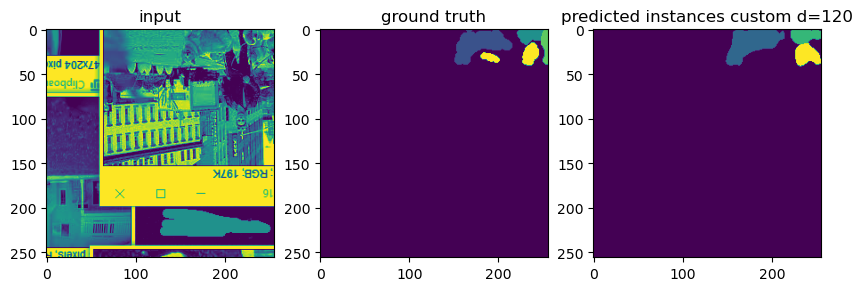

In [34]:

# run model on test images
n=74
masks = model.eval(X_train[n][0,:,:], channels=[0,1], diameter=40, cellprob_threshold=-0.5)[0]
fig = imshow_multi2d([X_train[n][0,:,:], Y[n], masks],['input','ground truth','predicted instances custom d=120'],1,3)


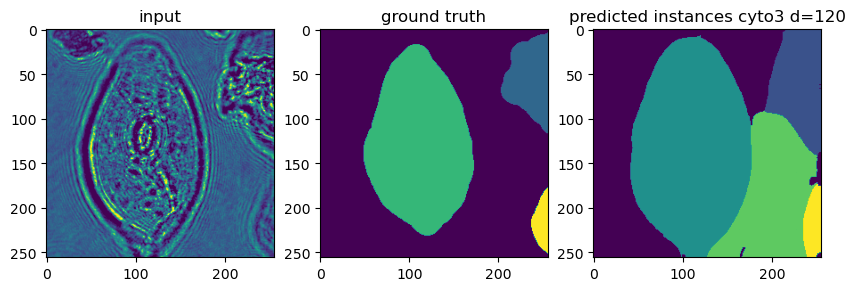

In [84]:

# run model on test images
masks = model_cyto3.eval(X_train[n][0,:,:], channels=[0,1],diameter=120, cellprob_threshold=-0.9, flow_threshold=0.8)[0]
fig = imshow_multi2d([X_train[n][0,:,:], Y[n], masks],['input','ground truth','predicted instances cyto3 d=120'],1,3)


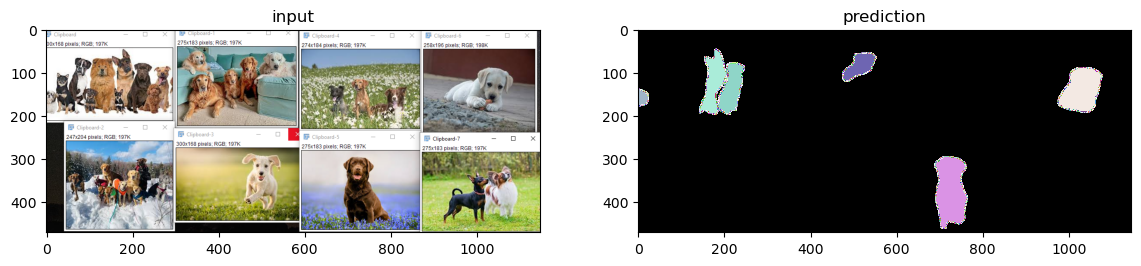

In [46]:
from skimage.io import imread
from tnia.plotting.plt_helper import random_label_cmap
from tnia.deeplearning.dl_helper import ray4_to_ellipsoid2d_labels
from csbdeep.utils import normalize

testim = imread(parent_path / 'dog_test.tif')
testim = normalize(testim,1,99.8, axis=(0,1))
labels = model.eval(testim, channels=[0, 1,2],diameter=60, cellprob_threshold=-0.9)[0]

fig = imshow_multi2d([testim,labels],['input','prediction'],1,2, width=14, height=8,colormaps=['gray', random_label_cmap()])


## View in Napari

In [47]:
import napari

viewer = napari.Viewer()
viewer.add_image(testim, name='testim')
viewer.add_labels(labels, name='labels')

<Labels layer 'labels' at 0x1cb9cd0b400>

In [17]:
from skimage.io import imsave

label_name = parent_path + r'/labels_cycle3.tif'
imsave(label_name, labels.astype('uint16'))

264163233.py (4): D:\images\tnia-python-images\forum\bees/labels_cycle3.tif is a low contrast image
